In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [2]:
# raw = pd.read_csv('./tr_eikon_eod_data.csv',
#     index_col=0, parse_dates=True).dropna()
# raw
########################
import joblib
raw = joblib.load('./mydf_nifty_prediction.p')
raw.fillna(0)
raw

,date,open,high,low,close,volume
0,2015-01-09 09:15:00+05:30,8285.45,8295.90,8285.45,8292.10,0
1,2015-01-09 09:16:00+05:30,8292.60,8293.60,8287.20,8288.15,0
2,2015-01-09 09:17:00+05:30,8287.40,8293.90,8287.40,8293.90,0
3,2015-01-09 09:18:00+05:30,8294.25,8300.65,8293.90,8300.65,0
4,2015-01-09 09:19:00+05:30,8300.60,8301.30,8298.75,8301.20,0
...,...,...,...,...,...,...
544331,2020-11-27 15:25:00+05:30,12970.65,12970.95,12960.15,12960.80,0
544332,2020-11-27 15:26:00+05:30,12960.05,12960.60,12946.35,12946.85,0
544333,2020-11-27 15:27:00+05:30,12946.85,12947.00,12927.95,12927.95,0
544334,2020-11-27 15:28:00+05:30,12928.35,12947.90,12928.35,12937.70,0


In [3]:
raw.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [4]:
# symbol = 'EUR='
# symbol
# ###################

symbol = 'close'
symbol

'close'

In [5]:
data = pd.DataFrame(raw[symbol])
data

,close
0,8292.10
1,8288.15
2,8293.90
3,8300.65
4,8301.20
...,...
544331,12960.80
544332,12946.85
544333,12927.95
544334,12937.70


In [6]:
data['returns'] = np.log(data / data.shift(1))
data['returns']

0              NaN
1        -0.000476
2         0.000694
3         0.000814
4         0.000066
            ...   
544331   -0.000760
544332   -0.001077
544333   -0.001461
544334    0.000754
544335    0.000398
Name: returns, Length: 544336, dtype: float64

In [7]:
data.dropna(inplace=True)

In [8]:
data['direction'] = np.sign(data['returns']).astype(int)

In [9]:
data.head()

,close,returns,direction
1,8288.15,-0.000476,-1
2,8293.90,0.000694,1
3,8300.65,0.000814,1
4,8301.20,0.000066,1
5,8300.00,-0.000145,-1


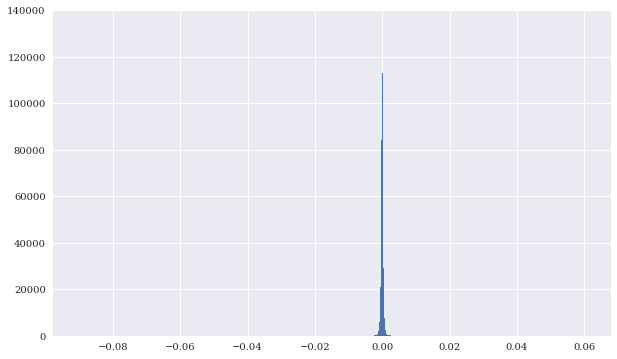

In [13]:
data['returns'].hist(bins=1000, figsize=(10, 6));

In [14]:
lags = 2

In [15]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [16]:
create_lags(data)

In [17]:
data.head()

,close,returns,direction,lag_1,lag_2
1,8288.15,-0.000476,-1,NaN,NaN
2,8293.90,0.000694,1,-0.000476,NaN
3,8300.65,0.000814,1,0.000694,-0.000476
4,8301.20,0.000066,1,0.000814,0.000694
5,8300.00,-0.000145,-1,0.000066,0.000814


In [18]:
data.dropna(inplace=True)

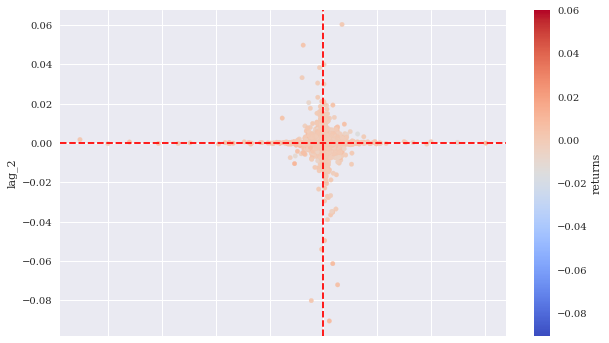

In [19]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns',
cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

In [20]:
################################################################################
######################### REGRESSION ###########################################
################################################################################

In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

data['pos_ols_1'] = model.fit(data[cols],data['returns']).predict(data[cols])
data['pos_ols_2'] = model.fit(data[cols],data['direction']).predict(data[cols])
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
3,9.231294e-06,0.020088
4,-1.098450e-05,-0.005523
5,-1.322885e-05,-0.011829
6,-3.474140e-07,0.003878
7,3.382908e-06,0.010378


In [22]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)
data['pos_ols_1'].value_counts()

 1    315287
-1    229046
Name: pos_ols_1, dtype: int64

In [23]:
data['pos_ols_2'].value_counts()

 1    456329
-1     88004
Name: pos_ols_2, dtype: int64

In [24]:
(data['pos_ols_1'].diff() != 0).sum()

258673

In [25]:
(data['pos_ols_2'].diff() != 0).sum()

147751

In [26]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [27]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        1.560526
strat_ols_1    2.422976
strat_ols_2    5.727535
dtype: float64

In [28]:
(data['direction'] == data['pos_ols_1']).value_counts()

False    272570
True     271763
dtype: int64

In [29]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     272491
False    271842
dtype: int64

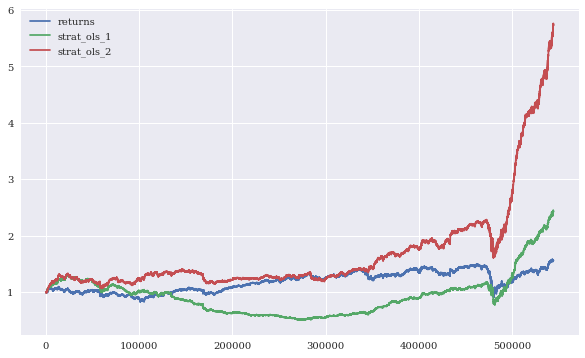

In [30]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [31]:
################################################################################
################################ CLUSTERING ####################################
################################################################################

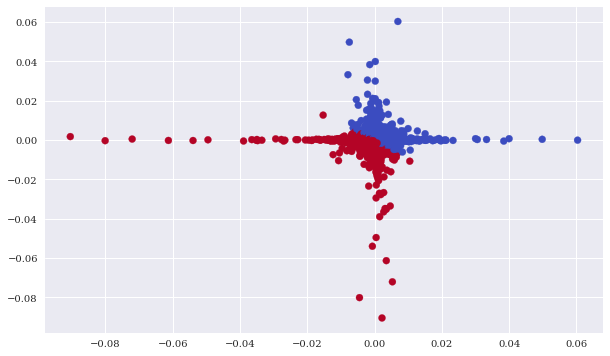

In [32]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0)
model.fit(data[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
random_state=0, tol=0.0001, verbose=0)
data['pos_clus'] = model.predict(data[cols])
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)
data['pos_clus'].values
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
c=data['pos_clus'], cmap='coolwarm');

In [33]:
data['strat_clus'] = data['pos_clus'] * data['returns']
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       1.560526
strat_clus    0.006008
dtype: float64

In [34]:
(data['direction'] == data['pos_clus']).value_counts()

False    278814
True     265519
dtype: int64

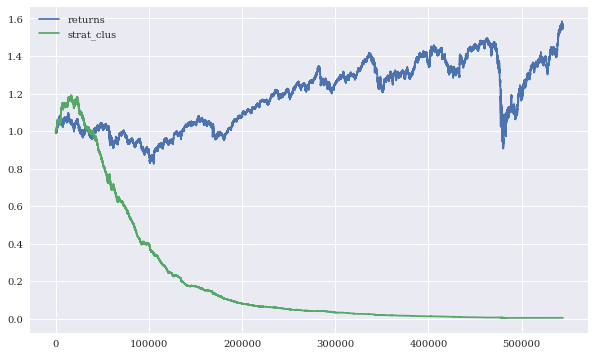

In [35]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [36]:
###################################################################
###################### FREQUENCY APPROACH #########################
###################################################################

In [37]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [38]:
create_bins(data)
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
3,1,0,1
4,1,1,1
5,1,1,-1
6,0,1,1
7,1,0,-1


In [39]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           68685
                       0            1173
                       1           66261
           1          -1           67434
                       0            1217
                       1           63176
1          0          -1           62213
                       0            1191
                       1           68424
           1          -1           69614
                       0            1568
                       1           73377
dtype: int64

In [40]:
res = grouped['direction'].size().unstack(fill_value=0)
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
res.style.apply(highlight_max, axis=1)

In [41]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)
(data['direction'] == data['pos_freq']).value_counts()

False    276858
True     267475
dtype: int64

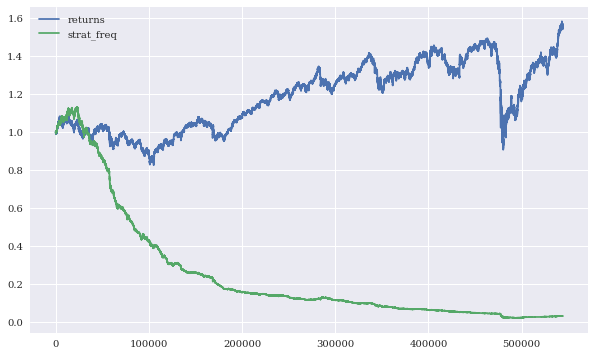

In [42]:
data['strat_freq'] = data['pos_freq'] * data['returns']
data[['returns', 'strat_freq']].sum().apply(np.exp)
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [43]:
###############################################################
##################### CLASSIFICATION ##########################
###############################################################
############## TWO BINARY FEATURE #############################
###############################################################

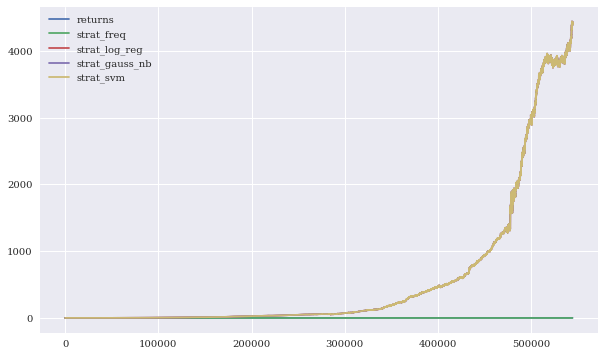

In [44]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
C = 1
models = {
'log_reg': linear_model.LogisticRegression(C=C),
'gauss_nb': GaussianNB(),
'svm': SVC(C=C)
}
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin],
        data['direction'])
        for model in models.keys()}
    
fit_models(data)

def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
        
        
derive_positions(data)
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')
    
evaluate_strats(data)
sel.insert(1, 'strat_freq')
data[sel].sum().apply(np.exp)

data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [45]:
#########################################################
################### FIVE BINARY FEATURRES ###############
#########################################################

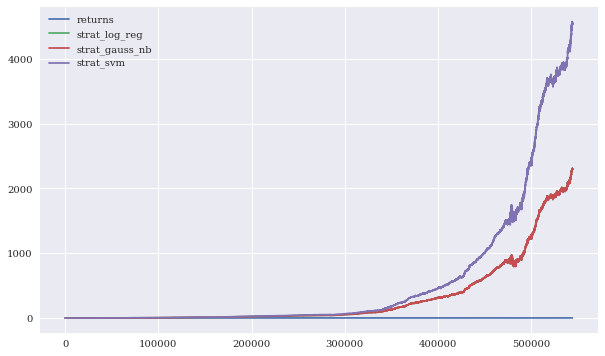

In [46]:
data = pd.DataFrame(raw[symbol]) 

data['returns'] = np.log(data/ data.shift(1)) 
    
data['direction'] = np.sign(data['returns']) 

lags = 5
create_lags(data)
data.dropna(inplace=True) 

create_bins(data)
cols_bin

data[cols_bin].head() 
        
data.dropna(inplace=True) 

fit_models(data)

derive_positions(data) 
    
evaluate_strats(data) 

data[sel].sum().apply(np.exp)

data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

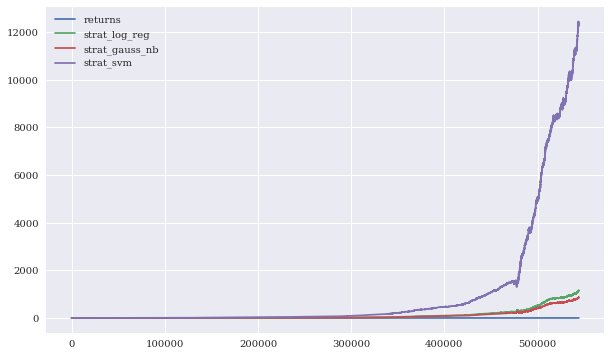

In [47]:
mu = data['returns'].mean()
v =data['returns'].std()
bins = [mu - v, mu, mu + v]
bins
create_bins(data, bins) 
    
data[cols_bin].head() 

fit_models(data) 
derive_positions(data) 

evaluate_strats(data) 

data[sel].sum().apply(np.exp)
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [48]:
###################################################################
################# SEQUENCIAL TRAIN/TEST SPLIT #####################
###################################################################

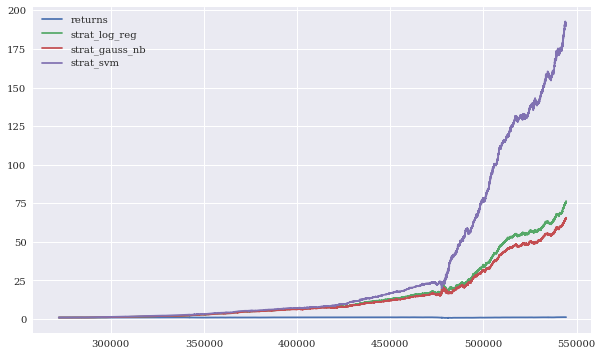

In [49]:
split = int(len(data) * 0.5) 
    
train = data.iloc[:split].copy()

fit_models(train)
test = data.iloc[split:].copy()

evaluate_strats(test)
derive_positions(test)
    
test[sel].sum().apply(np.exp) 

test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [50]:
#######################################################################
################## Randomized TrainTest Split #########################
#######################################################################

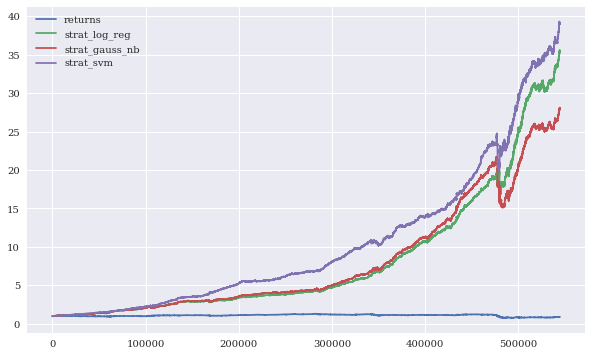

In [51]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(data, test_size=0.5, shuffle=True,random_state=100) 
train = train.copy().sort_index()
test = test.copy().sort_index()
fit_models(train) 
derive_positions(test) 
evaluate_strats(test) 
test[sel].sum().apply(np.exp)
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='lbfgs', alpha=1e-5,
hidden_layer_sizes=2 * [250],
random_state=1)
%time model.fit(data[cols_bin], data['direction'])

data['pos_dnn_sk'] = model.predict(data[cols_bin])
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
train, test = train_test_split(data, test_size=0.5,random_state=100)
train = train.copy().sort_index()
test = test.copy().sort_index()
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
hidden_layer_sizes=3 * [500], random_state=1)
%time model.fit(train[cols_bin], train['direction'])
test['pos_dnn_sk'] = model.predict(test[cols_bin])
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

fc = [tf.feature_column.numeric_column('lags')]

model = tf.estimator.DNNClassifier(hidden_units=3 * [500],n_classes=len(bins) + 1, feature_columns=fc)

def input_fn():
    fc = {'lags': tf.constant(data[cols_bin].values)}
    la = tf.constant(data['direction'].apply(lambda x: 0 if x < 0 else 1).values,
                     shape=[data['direction'].size, 1])
    return fc, la

model.train(input_fn=input_fn, steps=250)
model.evaluate(input_fn=input_fn, steps=1)
pred = np.array(list(model.predict(input_fn=input_fn)))
pred[:10]
data['pos_dnn_tf'] = np.where(pred > 0, 1, -1)
data['strat_dnn_tf'] = data['pos_dnn_tf'] * data['returns']
data[['returns', 'strat_dnn_tf']].sum().apply(np.exp)
data[['returns', 'strat_dnn_tf']].cumsum().apply(np.exp).plot(figsize=(10, 6));